<a href="https://colab.research.google.com/github/charlesm93/stanTutorial/blob/main/Nordic_Prob_AI/CourseScript_probAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nording Probabilistic AI summer school: Monte Carlo methods

2024. Instructor: Charles Margossian

This notebook contains R scripts to do the exercises. Throughout, we will use Stan. The scripts below install Stan, as well as some other useful packages.

In [1]:
rm(list = ls())
gc()

set.seed(1954)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,648667,34.7,1444128,77.2,1124268,60.1
Vcells,1204774,9.2,8388608,64.0,1924617,14.7


In [2]:
# Set size of output plots (adjust to your preferences)
options(repr.plot.width = 7, repr.plot.height = 3.5, repr.plot.res = 200)

## Install requisite packages

In [3]:
install_packages <- TRUE
if (install_packages) {
  install.packages("rjson")
  install.packages("posterior")
  install.packages("bayesplot")
  install.packages("outbreaks")
  install.packages("loo")
  install.packages("gridExtra")
}

Installing package into ‘/home/martin/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

Installing package into ‘/home/martin/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

also installing the dependencies ‘backports’, ‘magrittr’, ‘pkgconfig’, ‘generics’, ‘numDeriv’, ‘abind’, ‘checkmate’, ‘tibble’, ‘tensorA’, ‘distributional’, ‘matrixStats’


Installing package into ‘/home/martin/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

also installing the dependencies ‘colorspace’, ‘farver’, ‘labeling’, ‘munsell’, ‘RColorBrewer’, ‘viridisLite’, ‘stringi’, ‘R6’, ‘gtable’, ‘isoband’, ‘scales’, ‘withr’, ‘plyr’, ‘Rcpp’, ‘stringr’, ‘dplyr’, ‘ggplot2’, ‘ggridges’, ‘reshape2’, ‘tidyselect’


Installing package into ‘/home/martin/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

Installing package into ‘/home/martin/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

Installing package into ‘/home/martin/R/x86_64-pc-linux-gnu-library/4.4’
(

In [4]:
if (install_packages) {
  install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
  library(cmdstanr)
  install_cmdstan()
}

Installing package into ‘/home/martin/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ps’, ‘data.table’, ‘processx’


This is cmdstanr version 0.8.0

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- Use set_cmdstan_path() to set the path to CmdStan

- Use install_cmdstan() to install CmdStan

The C++ toolchain required for CmdStan is setup properly!

* Latest CmdStan release is v2.35.0

* Installing CmdStan v2.35.0 in /home/martin/.cmdstan/cmdstan-2.35.0

* Downloading cmdstan-2.35.0.tar.gz from GitHub...

* Download complete

* Unpacking archive...

* Building CmdStan binaries...



cp bin/linux-stanc bin/stanc
g++ -pipe   -pthread -D_REENTRANT  -O3 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials -DNO_FPRINTF_OUTPUT     -O3  -c -x c -include stan/lib/stan_math/lib/sundials_6.1.1/include/stan_sundials_printf_override.hpp stan/lib/stan_math/lib/sundials_6.1.1/src/nvector/serial/nvector_serial.c -o stan/lib/stan_math/lib/sundials_6.1.1/src/nvector/serial/nvector_serial.o
chmod +x bin/stanc
g++ -pipe   -pthread -D_REENTRANT  -O3 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials -DNO_FPRINTF_OUTPUT     -O3  -c -x c -include stan/lib/stan_math/lib/sundials_6.1.1/include/stan_sundials_printf_override.hpp stan/lib/stan_math/lib/sundials_6.1.1/src/sundials/sundials_math.c -o stan/lib/stan_math/lib/sundials_6.1.1/src/sundials/sundials_math.o
g++ -pipe   -pthread -D_REENTRANT  -O3 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1

* Finished installing CmdStan to /home/martin/.cmdstan/cmdstan-2.35.0


CmdStan path set to: /home/martin/.cmdstan/cmdstan-2.35.0



## Load packages

In [5]:
library(rjson)
library(bayesplot)
library(posterior)
library(ggplot2)
library(cmdstanr)
library(parallel)
library(loo)
library(outbreaks)
library(gridExtra)

This is bayesplot version 1.11.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

This is posterior version 1.5.0


Attaching package: ‘posterior’


The following object is masked from ‘package:bayesplot’:

    rhat


The following objects are masked from ‘package:stats’:

    mad, sd, var


The following objects are masked from ‘package:base’:

    %in%, match


This is loo version 2.7.0

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 



In [6]:
mc.cores = detectCores()

Utility function for analyzing the output of `loo` package.

In [7]:

is_summary <- function (fit, parms, psis_fit, log_ratios) {
  mean <- c()
  var <- c()
  q5 <- c()
  q25 <- c()
  q50 <- c()
  q75 <- c()
  q95 <- c()
  khat <- c()

  for (i in 1:length(parms)) {
    parm_draw <- fit$draws(parms[i])
    mean <- c(mean, E_loo(parm_draw, psis_fit, log_ratios = log_ratios, type = "mean")$value)
    var <- c(var, E_loo(parm_draw, psis_fit, log_ratios = log_ratios, type = "var")$value)
    q5 <- c(q5, E_loo(parm_draw, psis_fit, log_ratios = log_ratios, type = "quantile", probs = 0.05)$value)
    q25 <- c(q25, E_loo(parm_draw, psis_fit, log_ratios = log_ratios, type = "quantile", probs = 0.25)$value)
    q50 <- c(q50, E_loo(parm_draw, psis_fit, log_ratios = log_ratios, type = "quantile", probs = 0.5)$value)
    q75 <- c(q75, E_loo(parm_draw, psis_fit, log_ratios = log_ratios, type = "quantile", probs = 0.75)$value)
    q95 <- c(q95, E_loo(parm_draw, psis_fit, log_ratios = log_ratios, type = "quantile", probs = 0.95)$value)
    khat <- c(khat, E_loo(parm_draw, psis_fit, log_ratios = log_ratios, type = "mean")$pareto_k)
  }

  summary <- data.frame(parms = parms, mean = mean, var = var, q5 = q5, q25 = q25, q50 = q50,
                        q75 = q75, q95 = q95, khat = khat)
  return(summary)
}


## Bayesian Linear Regression



In [23]:
data <- list(N = 10,
             x = 1:10,
             y = c(12.03037, 13.86786, 16.00795, 18.29419, 20.26679, 22.38664,
                   23.95751, 25.71993, 28.09961, 30.46859))

# define starting distribution
init <- function() {
  list(sigma = rgamma(1, 1),
       beta = rnorm(1, mean = 1, sd = 1))
}

In [33]:
# transpile (translate Stan to C++ and then compile)
mod <- cmdstan_model("model/linear_intercept.stan")

In [34]:
# run sampler
fit <- mod$sample(data = data, 
    chains = 4,
    init = init,
    save_warmup = TRUE,
    parallel_chains = 4,
    iter_warmup = 1000,
)


Init values were only set for a subset of parameters. 
Missing init values for the following parameters:
 - chain 1: alpha
 - chain 2: alpha
 - chain 3: alpha
 - chain 4: alpha

To disable this message use options(cmdstanr_warn_inits = FALSE).




Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 1 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 1 Itera

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/Rtmp2agRyw/model-1545f618582846.stan', line 16, column 2 to column 22)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/Rtmp2agRyw/model-1545f618582846.stan', line 16, column 2 to column 22)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if t

Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 2 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 2 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 2 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 2 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 2 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 2 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 2 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 2 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Ch

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/Rtmp2agRyw/model-1545f618582846.stan', line 16, column 2 to column 22)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/Rtmp2agRyw/model-1545f618582846.stan', line 16, column 2 to column 22)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if t

Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 3 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 3 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 3 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 3 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 3 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 3 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 3 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 3 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 3 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 3 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 3 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Ch

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/Rtmp2agRyw/model-1545f618582846.stan', line 16, column 2 to column 22)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/Rtmp2agRyw/model-1545f618582846.stan', line 16, column 2 to column 22)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if t

Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 4 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 4 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 4 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 4 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 4 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 4 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 4 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 4 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 4 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 4 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 4 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 4 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 4 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 4 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 4 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 4 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 4 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 4 Iteration: 1800 / 2000 [ 90%]  (Sampling) 
Ch

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/Rtmp2agRyw/model-1545f618582846.stan', line 16, column 2 to column 22)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/Rtmp2agRyw/model-1545f618582846.stan', line 16, column 2 to column 22)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if t

Chain 1 finished in 0.0 seconds.
Chain 2 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.
Chain 4 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 0.3 seconds.



In [35]:
# Examine Stan's default summaries
fit$summary()

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,5.9566425,6.345565,1.48947764,1.23359733,3.0545235,7.5730955,1.002744,1115.578,976.8259
beta,2.0178959,2.018155,0.03352971,0.03063793,1.9626975,2.0714050,1.004025,1251.058,1284.5231
sigma,0.2858517,0.266649,0.09021117,0.07080453,0.1798821,0.4553033,1.004081,1073.225,1147.8525
alpha,10.0105665,10.013000,0.20682271,0.18933543,9.6806075,10.3444300,1.003760,1201.470,1194.9680
y_pred[1],12.0340689,12.033750,0.33492177,0.30548973,11.4928950,12.5807000,1.001218,2530.521,2464.2747
y_pred[2],14.0480832,14.043700,0.33402774,0.30897384,13.5074650,14.5849750,1.000776,3244.315,3099.1429
y_pred[3],16.0554688,16.055900,0.32295237,0.28473333,15.5374900,16.5884050,1.000483,2828.840,2931.8290
y_pred[4],18.0845855,18.085550,0.31962230,0.28703136,17.5764550,18.5866750,1.002036,3460.456,3311.6241
y_pred[5],20.1000554,20.100600,0.32121863,0.28955178,19.5836650,20.5976050,1.000877,3947.223,3270.8881


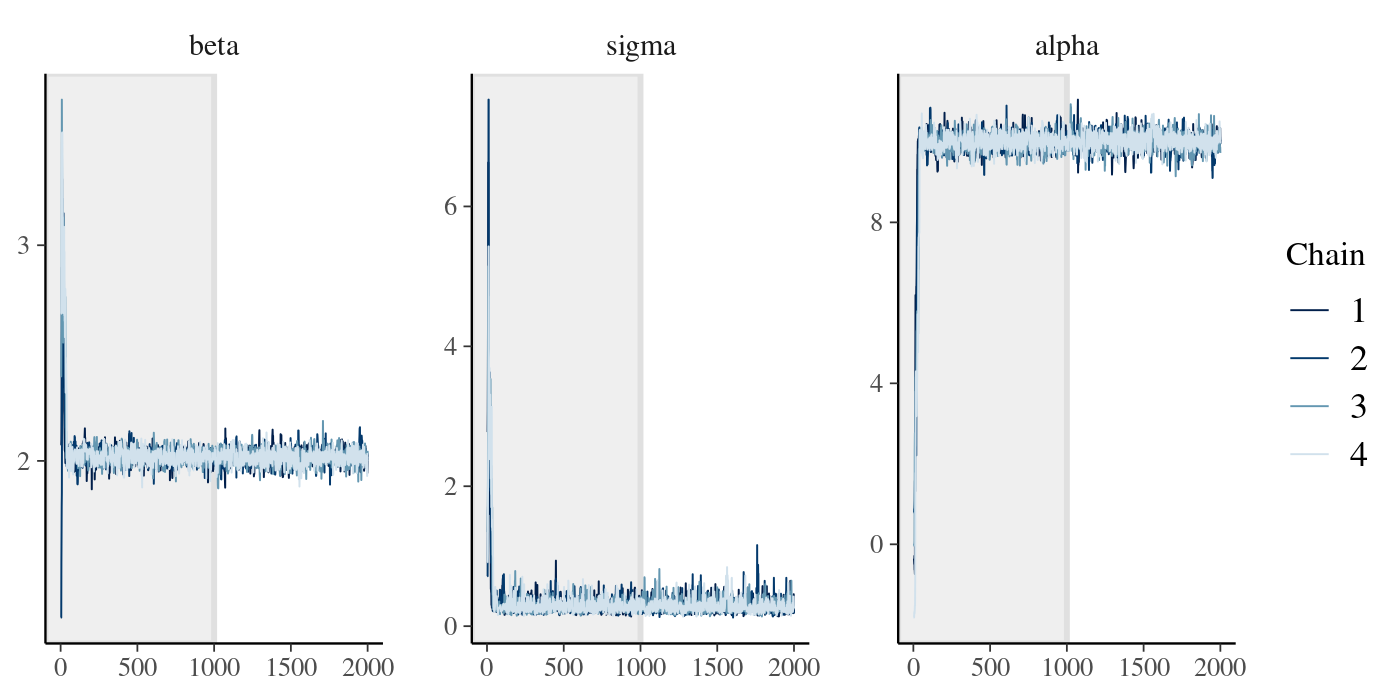

In [38]:
# Construct diagnostic plots
pars <- c("beta", "sigma", "alpha")
bayesplot::mcmc_trace(fit$draws(inc_warmup = TRUE),
                      n_warmup = 1000, pars = pars)


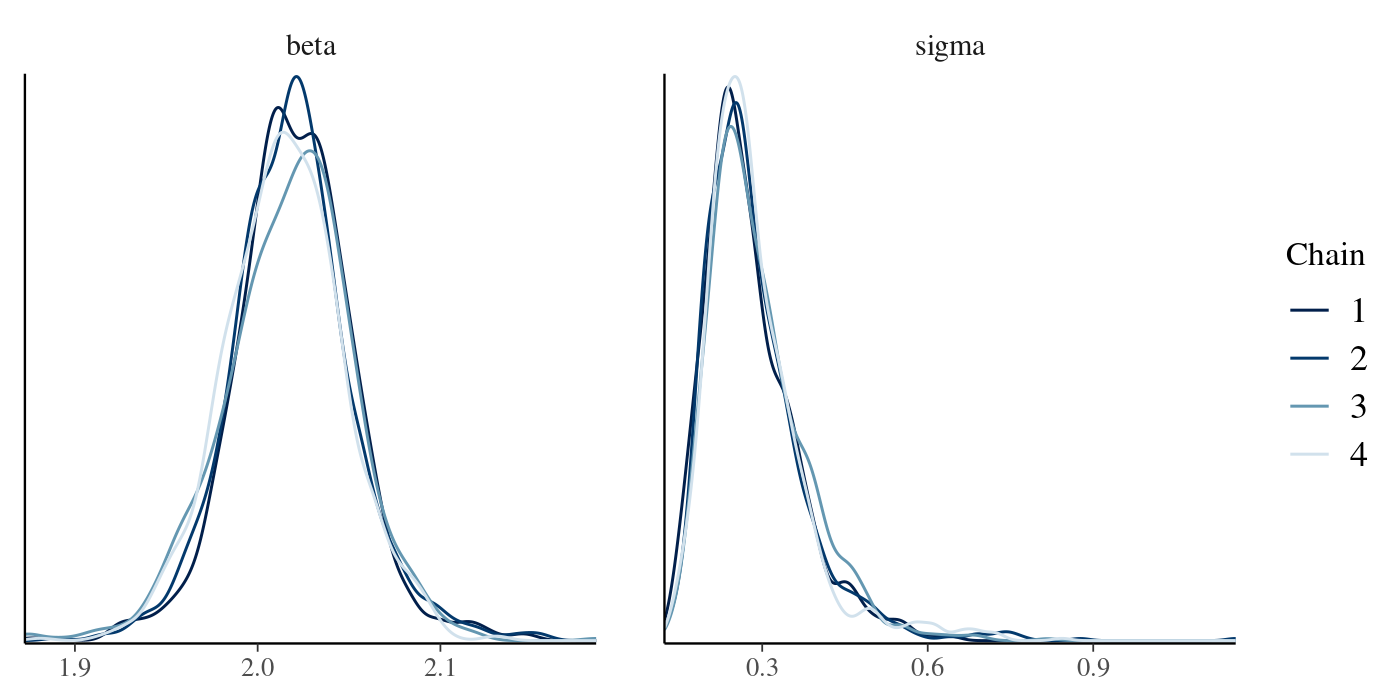

In [37]:
bayesplot::mcmc_dens_overlay(fit$draws(), pars = pars)

In [39]:
# Extract posterior predictive checks
yrep <- as.matrix(
  as_draws_df(fit$draws(variables = c("y_pred"))))
head(yrep)

y_pred[1],y_pred[2],y_pred[3],y_pred[4],y_pred[5],y_pred[6],y_pred[7],y_pred[8],y_pred[9],y_pred[10],.chain,.iteration,.draw
12.5104,13.9131,16.4208,18.3493,20.0769,22.3707,24.0875,26.5385,28.7261,30.5711,1,1,1
11.9441,13.7060,15.8141,17.8969,19.9680,21.9062,23.8576,25.9460,27.8814,29.6472,1,2,2
12.1209,13.9842,16.0344,17.9550,20.1269,21.4478,23.9379,26.0369,28.3288,29.9818,1,3,3
12.0534,13.8930,16.1876,18.0838,19.9513,22.1187,24.2063,25.8802,28.0085,30.6533,1,4,4
11.4827,14.1117,15.5570,18.2747,20.3562,22.3673,24.4933,26.1608,27.6677,30.0005,1,5,5
11.9856,14.0195,16.0128,18.4987,19.9585,22.0090,24.2174,26.1064,28.5109,30.4000,1,6,6


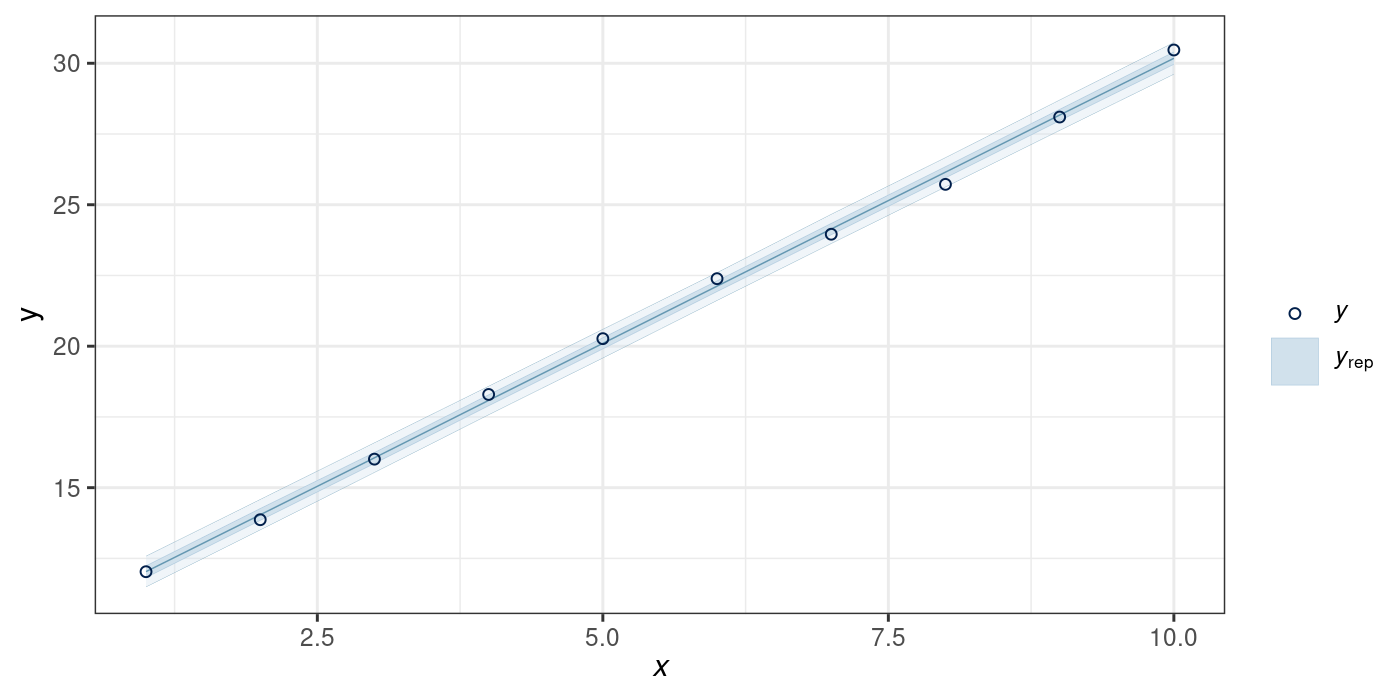

In [40]:
# We don't need the chain, iteration and draw ID, so let's remove them.
yrep <- yrep[, -(11:13)]

# Plot the posterior predictions and compare it to the real data.
bayesplot::ppc_ribbon(y = data$y, yrep = yrep, x = data$x,
                      y_draw = "point") +
  theme_bw() +
  ylab("y")


## Disease Transmission model

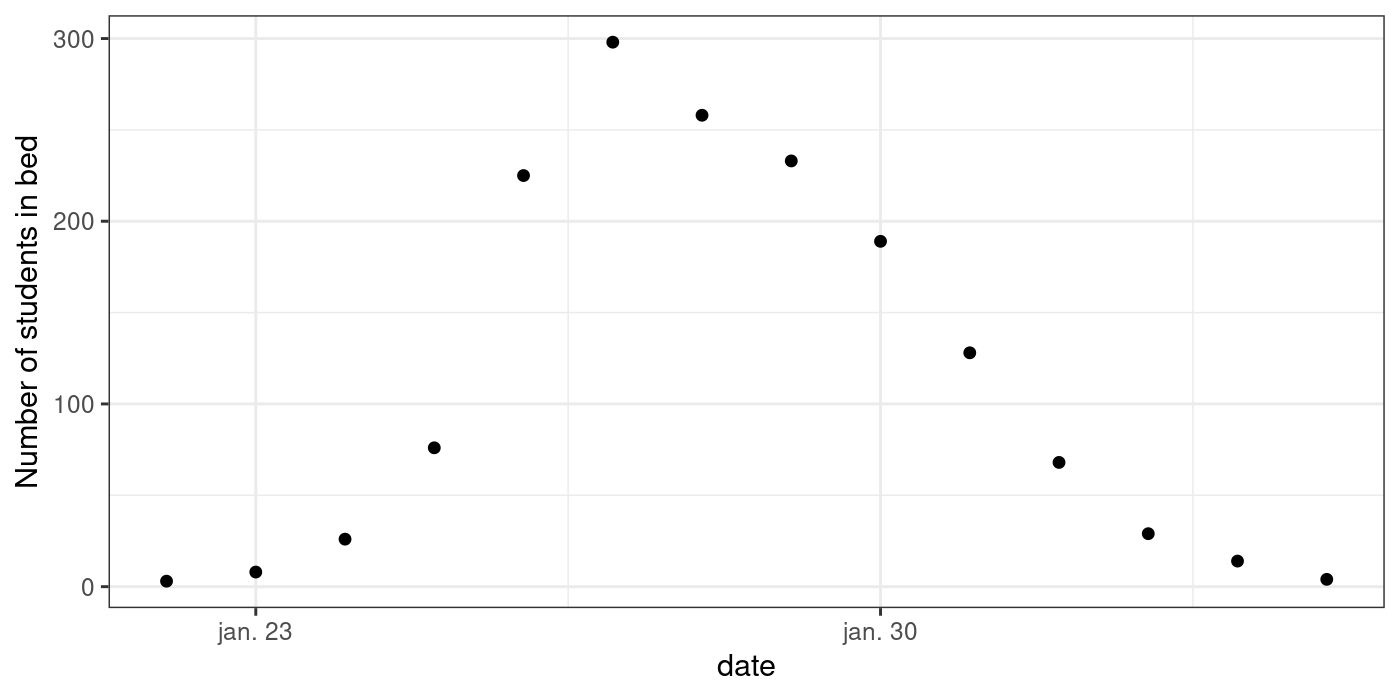

In [41]:
theme_set(theme_bw())
ggplot(data = influenza_england_1978_school) +
  geom_point(mapping = aes(x = date, y = in_bed)) +
  labs(y = "Number of students in bed")


In [42]:
# create a data list to be passed to Stan
cases <- influenza_england_1978_school$in_bed
N <- 763;
n_days <- length(cases)
t <- seq(0, n_days, by = 1)
t0 = 0
t <- t[-1]

#initial conditions
i0 <- 1
s0 <- N - i0
r0 <- 0
y0 = c(S = s0, I = i0, R = r0)

data_sir <- list(n_days = n_days, y0 = y0, t0 = t0, ts = t,
                 N = N, cases = cases)


In [43]:
# define starting distribution
init <- function() {
  list(beta = abs(rnorm(1, mean = 2, sd = 1)),
       gamma = abs(rnorm(1, mean = 0.4, sd = 0.5)),
       phi_inv = rexp(1, rate = 5))
}

# transpile (translate Stan to C++ and then compile)
mod <- cmdstan_model("model/sir.stan")

n_chains <- 4
fit <- mod$sample(data = data_sir,
                  init = init,
                  save_warmup = TRUE,
                  parallel_chains = 4,
                  num_warmup = 1000,
                  num_samples = 1000)


Syntax error in '/tmp/Rtmp2agRyw/model-1545f6e5cd393.stan', line 12, column 15 to column 16, parsing error:
   -------------------------------------------------
    10:      
    11:      // CODE: return derivative of y
    12:      dy_dt[1] = ;
                        ^
    13:      dy_dt[2] = ;
    14:      dy_dt[3] = ;
   -------------------------------------------------

Ill-formed assignment statement. Expected an expression followed by ";" next.


make: *** [make/program:64: /tmp/Rtmp2agRyw/model-1545f6e5cd393.hpp] Error 1




ERROR: Error: An error occured during compilation! See the message above for more information.


In [ ]:
pars <- c("gamma", "beta", "phi", "R0")
fit$summary(variables = pars)

bayesplot::mcmc_trace(fit$draws(inc_warmup = TRUE),
                      n_warmup = 1000, pars = pars)
bayesplot::mcmc_dens_overlay(fit$draws(), pars = pars)

# Extract posterior predictive checks
pred_cases <- as.matrix(
  as_draws_df(fit$draws(variables = c("pred_cases"))))[, -(15:17)]

bayesplot::ppc_ribbon(y = data_sir$cases, yrep = pred_cases,
                      x = data_sir$ts, y_draw = "point") +
  theme_bw() +
  ylab("cases") + xlab("days")

In [ ]:
## Run same model with a Poisson likelihood

mod <- cmdstan_model("model/sir_poisson.stan")

fit_poisson <- mod$sample(data = data_sir,
                          init = init,
                          save_warmup = TRUE,
                          parallel_chains = 4,
                          num_warmup = 1000,
                          num_samples = 1000)



In [ ]:
fit_poisson$summary(variables = pars)

pred_cases_poisson <- as.matrix(
  as_draws_df(fit_poisson$draws(variables = c("pred_cases"))))[, -(15:17)]

bayesplot::ppc_ribbon(y = data_sir$cases, yrep = pred_cases_poisson,
                      x = data_sir$ts, y_draw = "point") +
  theme_bw() +
  ylab("cases") + xlab("days")

In [ ]:
# compute PSIS-loo estimate

log_lik_draws <- fit$draws("log_lik")
loo_estimate <- loo(log_lik_draws, r_eff = relative_eff(log_lik_draws))


log_lik_draws_poisson <- fit_poisson$draws("log_lik")
loo_estimate_poisson <-
  loo(log_lik_draws_poisson, r_eff = relative_eff(log_lik_draws_poisson))

print(loo_estimate_poisson)
print(loo_estimate)